<a href="https://colab.research.google.com/github/mouli142005/color_detection/blob/main/nm_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⏳ Fetching data from ThingSpeak...
✅ Data loaded successfully!
                  created_at  entry_id    field1    field2    field3  \
15 2025-10-29 09:44:55+00:00        16  59.60000  68.00000  66.00000   
16 2025-10-29 09:45:32+00:00        17  62.50000  84.50000  66.00000   
17 2025-10-29 09:46:10+00:00        18  62.50000  84.50000  66.00000   
18 2025-10-29 09:46:53+00:00        19  62.50000  84.50000  66.00000   
19 2025-10-29 09:47:29+00:00        20  62.50000  51.50000  66.00000   

    temperature  humidity  vibration  
15         59.6      68.0       66.0  
16         62.5      84.5       66.0  
17         62.5      84.5       66.0  
18         62.5      84.5       66.0  
19         62.5      51.5       66.0  


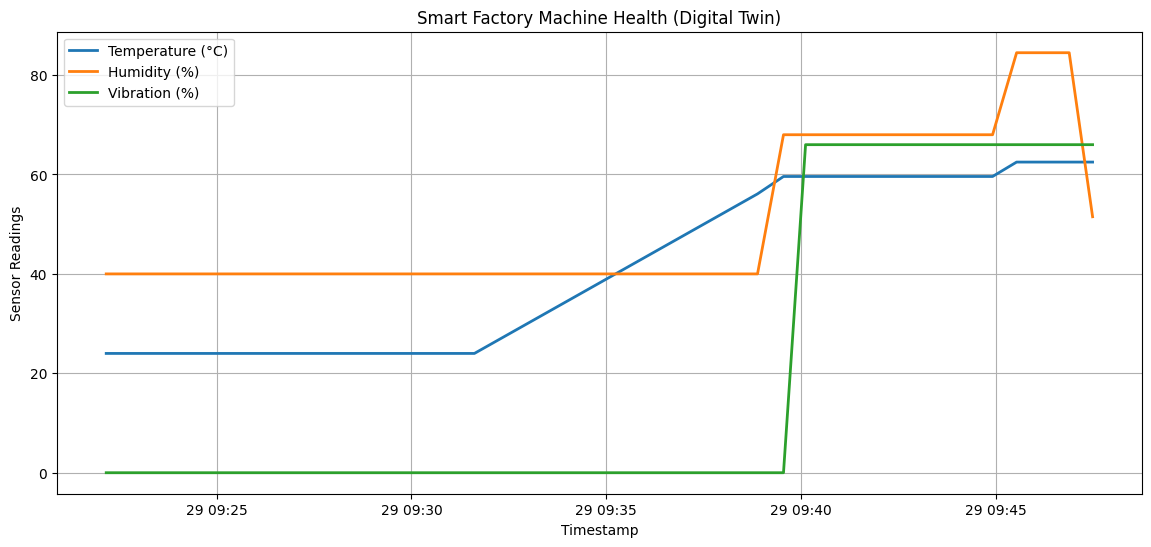


🚨 Predictive Maintenance Summary 🚨
Temp_Alert    15
Vib_Alert      0
dtype: int64


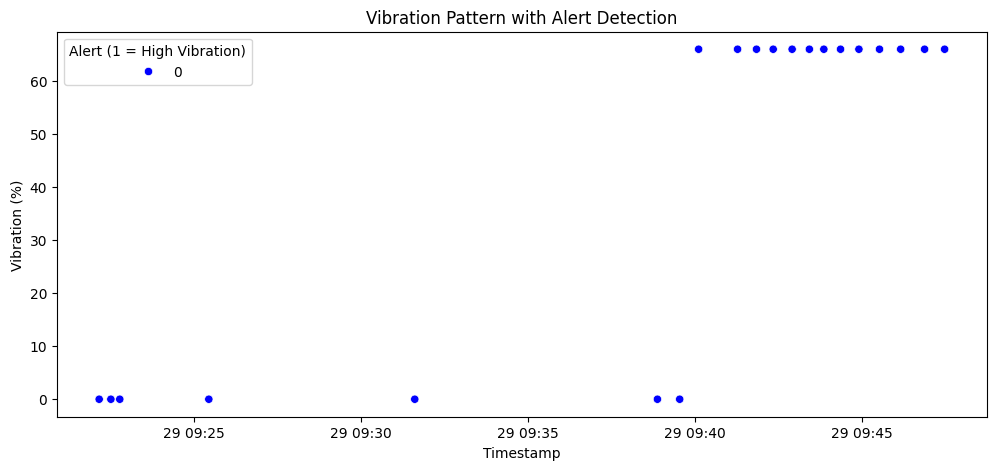

In [1]:
# ============================================================
# Smart Factory Digital Twin with Predictive Maintenance
# Google Colab - ThingSpeak Integration (Debug Safe Version)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime

# ====== ThingSpeak Channel Info ======
CHANNEL_ID = "3137787"  # ✅ your ThingSpeak channel ID
READ_API_KEY = "7OBVYPIG9NUB74QM"        # leave blank if channel is public
# If your channel is private, paste the full read API key between the quotes.

if READ_API_KEY:
    URL = f"https://api.thingspeak.com/channels/{CHANNEL_ID}/feeds.json?api_key={READ_API_KEY}&results=200"
else:
    URL = f"https://api.thingspeak.com/channels/{CHANNEL_ID}/feeds.json?results=200"

print("⏳ Fetching data from ThingSpeak...")
response = requests.get(URL)

# --- Check for valid response ---
if response.status_code != 200:
    raise Exception(f"❌ HTTP error: {response.status_code}")

try:
    data = response.json()
except Exception as e:
    print("⚠️ Could not decode JSON:", e)
    print("Response text:\n", response.text)
    raise SystemExit()

# --- Validate data structure ---
if not isinstance(data, dict) or "feeds" not in data:
    print("⚠️ Unexpected response from ThingSpeak:")
    print(data)
    raise SystemExit("❌ Check your Channel ID or READ API Key — no valid JSON feed found.")

feeds = data["feeds"]
if len(feeds) == 0:
    raise SystemExit("⚠️ No feeds found. Make sure your ESP32 has uploaded data.")

# ====== Create DataFrame ======
df = pd.DataFrame(feeds)
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
df["temperature"] = pd.to_numeric(df["field1"], errors="coerce")
df["humidity"] = pd.to_numeric(df["field2"], errors="coerce")
df["vibration"] = pd.to_numeric(df["field3"], errors="coerce")
df = df.dropna(subset=["temperature", "humidity", "vibration"]).reset_index(drop=True)

print("✅ Data loaded successfully!")
print(df.tail())

# ====== Plot Data ======
plt.figure(figsize=(14,6))
plt.plot(df["created_at"], df["temperature"], label="Temperature (°C)", linewidth=2)
plt.plot(df["created_at"], df["humidity"], label="Humidity (%)", linewidth=2)
plt.plot(df["created_at"], df["vibration"], label="Vibration (%)", linewidth=2)
plt.legend()
plt.title("Smart Factory Machine Health (Digital Twin)")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Readings")
plt.grid(True)
plt.show()

# ====== Predictive Maintenance Logic ======
df["Temp_Alert"] = np.where(df["temperature"] > 35, 1, 0)
df["Vib_Alert"] = np.where(df["vibration"] > 80, 1, 0)

# ====== Summary ======
alerts = df[["Temp_Alert", "Vib_Alert"]].sum()
print("\n🚨 Predictive Maintenance Summary 🚨")
print(alerts)

# ====== Visualize Anomalies ======
plt.figure(figsize=(12,5))
sns.scatterplot(
    data=df,
    x="created_at",
    y="vibration",
    hue="Vib_Alert",
    palette={0: "blue", 1: "red"}
)
plt.title("Vibration Pattern with Alert Detection")
plt.xlabel("Timestamp")
plt.ylabel("Vibration (%)")
plt.legend(title="Alert (1 = High Vibration)")
plt.show()
